In [1]:

# ##########################################################
# ################ I Import des données ####################
# ##########################################################
import pandas as pd

df = pd.read_csv('SBAnational.csv', low_memory=False)
df = df.sample(n = 10000)
# print(df.head())
# print(df.info())

# ##########################################################
# ################ II Nettoyage des données ################
# ##########################################################

def cleaning(df):


    # Columns Selection
    df = df.drop(columns=['Name', 'LoanNr_ChkDgt', 'Bank', 
                     'BankState', 'DisbursementDate', 'ApprovalDate', 
                    'ApprovalFY', 'FranchiseCode', 'Zip', 'City', 'ChgOffDate', 'SBA_Appv', 'BalanceGross', 'DisbursementGross', 'ChgOffPrinGr'])
    # Deal with NA
    df = df.dropna(subset=['MIS_Status']) 

    # Data formating for training data (outside pipe)
    df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')    
    df['RevLineCr'] = df['RevLineCr'].mask(df.RevLineCr.isin(['0','T','1','R','`','2','C','3',',','7','A','5','.','4','-','Q']))   
    df['LowDoc'] = df['LowDoc'].mask(df.LowDoc.isin(['0','C','S','A','R','1'])) 
    df['NewExist'] = df['NewExist'].replace({2:False, 1:True})   
    df['NAICS'] = df['NAICS'].astype('str').apply(lambda x : x[:2])    
    return df

df = cleaning(df)

/var/folders/py/4rt338cj1ks4z3332m7l3f880000gp/T/ipykernel_80960/500171733.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',','').str.strip().astype('float64').astype('int64')


In [12]:
# ##########################################################
# ################ III Train / Test / Split  ###############
# ##########################################################


from sklearn.model_selection import train_test_split
y = df['MIS_Status'].replace({'P I F':0, 'CHGOFF':1}) 
X = df.drop(['MIS_Status'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False,test_size=0.2, random_state=42)

In [4]:
# ##########################################################
# ############### IV Construction du Pipeline ##############
# ##########################################################


# ############### IV.a Numeric features ##############
numeric_features = list(X.select_dtypes(include=['int', 'float']).columns)

In [13]:
len(numeric_features)

6

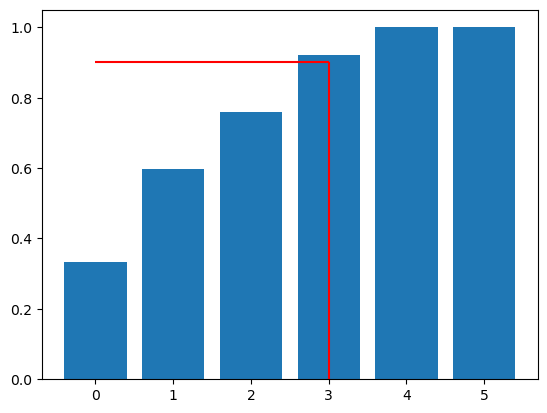

In [6]:
####### Analyse best PCA

from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [7]:


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_transformer = Pipeline([
        ('standard', StandardScaler()),  # Centrer réduire
        ('pca', PCA(n_components=4)) # après standardisation
        ])


# ############### IV.c Categorial features ##############
categorial_features = ['RevLineCr', 'LowDoc', 'NewExist', 'NAICS', 'State']

from sklearn.preprocessing import OneHotEncoder
categorical_transformer = OneHotEncoder(sparse=True)



# ############### IV.d Combinaison ##############
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ],
    remainder="passthrough" 
)


############### IV.d Estimator ##############
from xgboost import XGBClassifier
xg = XGBClassifier()


# ############### IV.d Final_pipe ##############

from sklearn.pipeline import Pipeline
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', xg)
])



/usr/local/Caskroom/miniconda/base/envs/machine-learning/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
# ##########################################################
# ################ V Train and evaluate ####################
# ##########################################################

from run_experiment import run_experiment



In [9]:
# ############### V.b Cross Validation ##############

from sklearn.model_selection import KFold

# define evaluation
cv = KFold(n_splits=5, random_state=1,shuffle = True)

# ############### V.c Hyparameters space setting ##############

# import numpy as np

positives = sum(y) / len(y)
negatives = 1 - positives
scale_ratio = negatives / positives

space = {'clf__max_depth' : [7,12,15],
              'clf__learning_rate' : [0.5],
              'clf__gamma' : [1],
              'clf__reg_lambda' : [15],
              'clf__scale_pos_weight' : [scale_ratio]
              }

# ############### V.d RandomSearch and GridSearc ##############


from sklearn.model_selection import GridSearchCV
model = GridSearchCV(
    pipe,
    space,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    cv=cv
)


In [10]:
import mlflow

experiment_id = mlflow.create_experiment("loan_analysis")

In [11]:
with mlflow.start_run(experiment_id=experiment_id) as run:
    model_fit = run_experiment(model, "classification", mlflow_tracking=True)

    for param,value in model_fit["clf"].get_params():
        mlflow.log_param(param, value)
    mlflow.log_param("PCA", True) 

NameError: name 'X_train' is not defined

[13:51:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:51:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

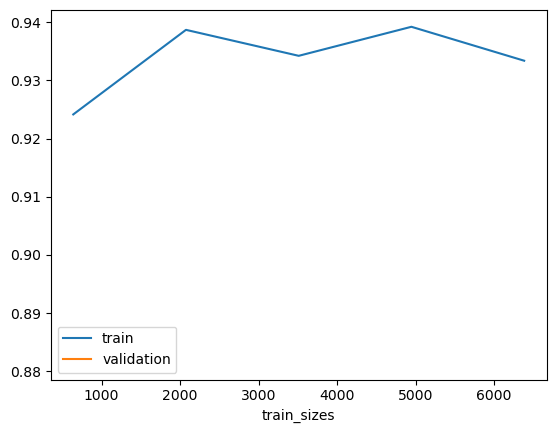

In [71]:
import warnings
warnings.filterwarnings('ignore')
############### V.f LearningCurve ##############

best_model_params = model_fit["clf"].get_params()
xg_best = XGBClassifier(**best_model_params)
best_pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('clf', xg_best)
])

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

N, train_score, val_score = learning_curve(best_pipe, X_train, y_train,cv=cv)

[ 638 2074 3511 4947 6384]


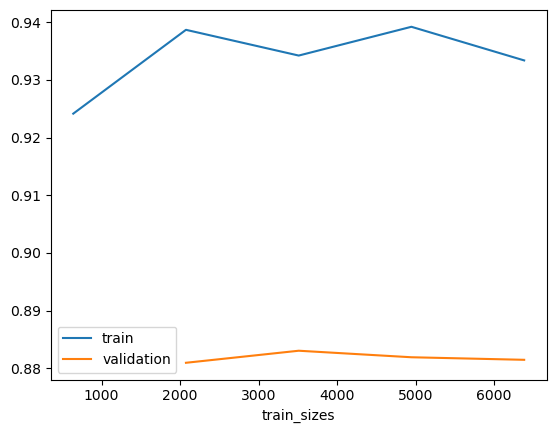

In [78]:
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()